In [659]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tsfresh as tsf
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [660]:
df = pd.read_csv("../data/kpi.csv")

In [661]:
df.head()

,Unnamed: 0,timestamp,value,label,KPI ID
0,1093099,1491041280,7934.0,0,e0770391decc44ce
1,1093100,1491041340,7782.0,0,e0770391decc44ce
2,1093101,1491041400,7349.0,0,e0770391decc44ce
3,1093102,1491041460,7426.0,0,e0770391decc44ce
4,1093103,1491041520,7447.0,0,e0770391decc44ce


In [662]:
df['ts']=pd.to_datetime(df['timestamp'], unit='s')
df.index = df['ts']
df = df[['ts', 'value', 'label']]
df.head()

,ts,value,label
ts,,,
2017-04-01 10:08:00,2017-04-01 10:08:00,7934.0,0
2017-04-01 10:09:00,2017-04-01 10:09:00,7782.0,0
2017-04-01 10:10:00,2017-04-01 10:10:00,7349.0,0
2017-04-01 10:11:00,2017-04-01 10:11:00,7426.0,0
2017-04-01 10:12:00,2017-04-01 10:12:00,7447.0,0


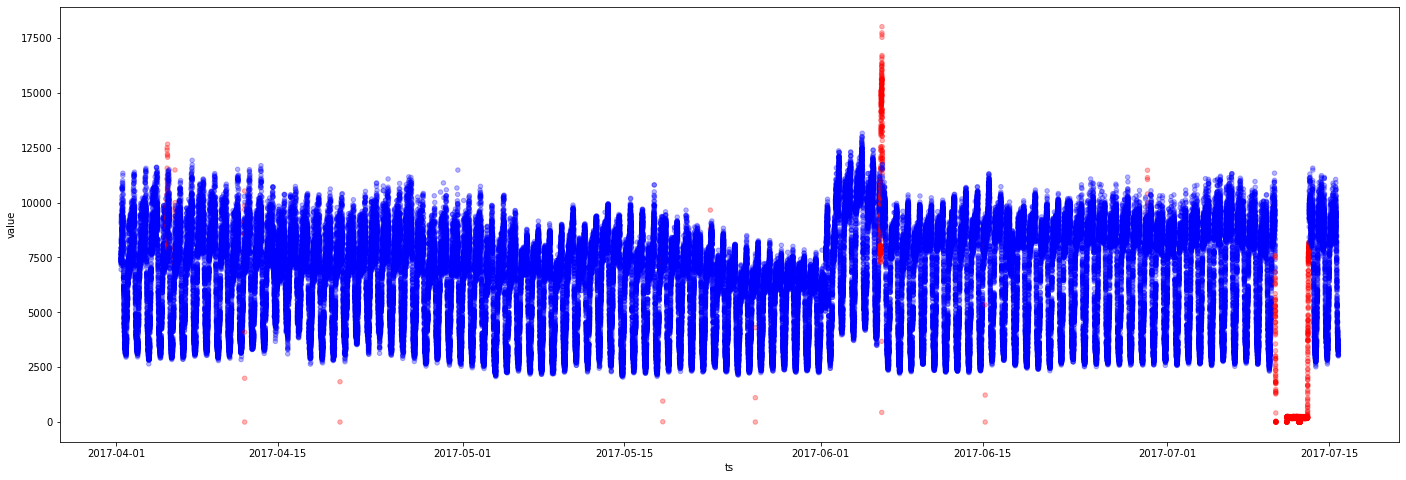

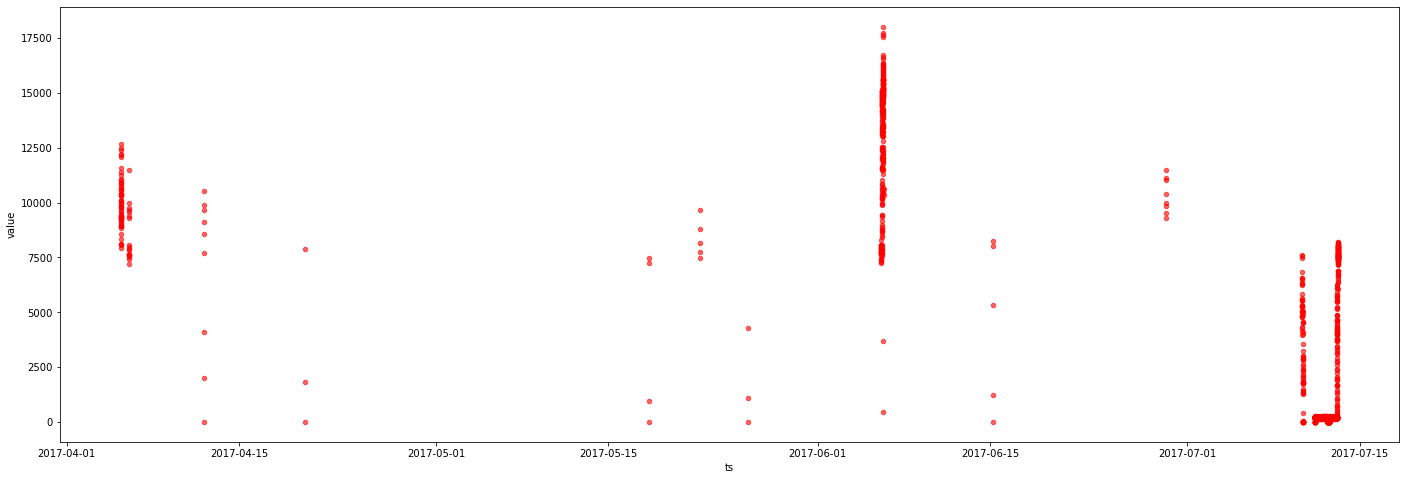

In [663]:
plt.rcParams['figure.figsize'] = (24,8)
df.plot(x="ts", y="value", kind="scatter", c=['b' if l==0 else 'r' for l in df["label"]], alpha=0.3)
df[df['label']==1].plot(x="ts", y="value", kind="scatter", c='r', alpha=0.6)
plt.show()

In [664]:
def extracted_features(df, n=10):
    df = ts_time_feature_generate(df)
    df = ts_rolling_statistics_feature_generate(df, n)
    df = ts_lag_feature_generate(df, n)
    df = ts_linear_feature_generate(df, n)
    df = ts_fft_feature_generate(df, n)
    df = ts_wavelet_feature_generate(df, n)
    df = ts_wavelet_feature_generate(df, n)
    return df


def ts_time_feature_generate(data_df):
    # 时间特性，要看训练数据的时间区间这些值是否有价值
    data_df['quarter'] = data_df['ts'].dt.quarter
    data_df['month'] = data_df['ts'].dt.month
    data_df['day'] = data_df['ts'].dt.day
    data_df['dayofweek'] = data_df['ts'].dt.dayofweek
    data_df['weekofyear'] = data_df['ts'].dt.isocalendar().week
    data_df['hour'] = data_df['ts'].dt.hour

    # 这些特征一般跟业务属性强关系
    data_df['is_year_start'] = data_df['ts'].dt.is_year_start.astype(np.int)
    data_df['is_year_end'] = data_df['ts'].dt.is_year_end.astype(np.int)
    data_df['is_quarter_start'] = data_df['ts'].dt.is_quarter_start.astype(np.int)
    data_df['is_quarter_end'] = data_df['ts'].dt.is_quarter_end.astype(np.int)
    data_df['is_month_start'] = data_df['ts'].dt.is_month_start.astype(np.int)
    data_df['is_month_end'] = data_df['ts'].dt.is_month_end.astype(np.int)
    data_df['is_weekend'] = data_df['dayofweek'].apply(lambda x: 1 if x == 0 or x == 6 else 0)

    # 是否时一天的高峰时段 8~18
    data_df['day_high'] = data_df['hour'].apply(lambda x: 1 if 8 < x < 18 else 0)
    # 是否是批跑时段
    data_df['day_night'] = data_df['hour'].apply(lambda x: 1 if 0 < x < 6 else 0)

    return data_df


def ts_rolling_statistics_feature_generate(data_df, n):
    data_df[f'rolling_{n}_avg'] = data_df["value"].rolling(n).mean().fillna(method='bfill')
    data_df[f'rolling_{n}_median'] = data_df["value"].rolling(n).median().fillna(method='bfill')
    data_df[f'rolling_{n}_max'] = data_df["value"].rolling(n).max().fillna(method='bfill')
    data_df[f'rolling_{n}_min'] = data_df["value"].rolling(n).min().fillna(method='bfill')
    data_df[f'rolling_{n}_std'] = data_df["value"].rolling(n).std().fillna(method='bfill')
    data_df[f'rolling_{n}_var'] = data_df["value"].rolling(n).var().fillna(method='bfill')

    def mad(x):
        return np.fabs(x - x.mean()).mean()

    data_df[f'rolling_{n}_mad'] = data_df["value"].rolling(n).apply(mad, raw=True).fillna(method='bfill')
    data_df[f'rolling_{n}_skew'] = data_df["value"].rolling(n).skew().fillna(method='bfill')
    data_df[f'rolling_{n}_kurt'] = data_df["value"].rolling(n).kurt().fillna(method='bfill')
    data_df[f'rolling_{n}_corr'] = data_df["value"].rolling(n).corr().fillna(method='bfill')
    data_df[f'rolling_{n}_cov'] = data_df["value"].rolling(n).cov().fillna(method='bfill')
    data_df[f'rolling_{n}_q1'] = data_df["value"].rolling(n).quantile(0.25).fillna(method='bfill')
    data_df[f'rolling_{n}_q3'] = data_df["value"].rolling(n).quantile(0.75).fillna(method='bfill')
    data_df[f'rolling_{n}_ewma'] = data_df["value"].rolling(n).apply(lambda data: data.ewm(com=0.5).mean()[-1]).fillna(
        method="bfill")

    return data_df


def ts_lag_feature_generate(data_df, *lags):
    data_df[f'diff_1'] = data_df["value"] - data_df["value"].shift(1)
    data_df[f'diff_1'] = data_df[f'diff_1'].fillna(value=0.0)
    data_df[f'diff_2'] = data_df["diff_1"] - data_df["diff_1"].shift(1)
    data_df[f'diff_2'] = data_df[f'diff_2'].fillna(value=0.0)
    for n in lags:
        data_df[f'ago_{n}_diff_1'] = (data_df["value"] - data_df["value"].shift(n)).fillna(value=0)
    return data_df


def ts_linear_feature_generate(data_df, n):
    data_df[f'rolling_{n}_linear_trend_slope'] = data_df["value"].rolling(n) \
        .apply(
        lambda data: list(tsf.feature_extraction.feature_calculators.linear_trend(data, [{'attr': 'slope'}]))[0][1])
    data_df[f'rolling_{n}_linear_trend_intercept'] = data_df["value"].rolling(n) \
        .apply(
        lambda data: list(tsf.feature_extraction.feature_calculators.linear_trend(data, [{'attr': 'intercept'}]))[0][1])

    return data_df


def ts_fft_feature_generate(data_df, n):
    data_df[f'rolling_{n}_fft_agg_centroid'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_aggregated(data, [{'aggtype': 'centroid'}]))[0][1])
    data_df[f'rolling_{n}_fft_agg_variance'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_aggregated(data, [{'aggtype': 'variance'}]))[0][1])
    # 一般生成的是空值，暂时删除
    # data_df[f'rolling_{n}_fft_agg_skew']=data_df["value"].rolling(n)\
    #    .apply(lambda data:list(tsf.feature_extraction.feature_calculators.fft_aggregated(data, [{'aggtype': 'skew'}]))[0][1])
    # data_df[f'rolling_{n}_fft_agg_kurtosis']=data_df["value"].rolling(n)\
    #    .apply(lambda data:list(tsf.feature_extraction.feature_calculators.fft_aggregated(data, [{'aggtype': 'kurtosis'}]))[0][1])
    data_df[f'rolling_{n}_fft_coeff_angle'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_coefficient(data, [{'coeff': 2, 'attr': 'angle'}]))[
                   0][1])
    data_df[f'rolling_{n}_fft_coeff_real'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_coefficient(data, [{'coeff': 2, 'attr': 'real'}]))[
                   0][1])
    data_df[f'rolling_{n}_fft_coeff_abs'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_coefficient(data, [{'coeff': 2, 'attr': 'abs'}]))[0][
                   1])
    data_df[f'rolling_{n}_fft_coeff_imag'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_coefficient(data, [{'coeff': 2, 'attr': 'imag'}]))[
                   0][1])

    return data_df


def ts_wavelet_feature_generate(data_df, n):
    data_df[f'rolling_{n}_wavelet_cwt_coeff'] = data_df["value"].rolling(n) \
        .apply(lambda data: list(tsf.feature_extraction.feature_calculators.cwt_coefficients(data, [
        {'widths': tuple([2, 2, 2]), 'coeff': 2, 'w': 2}]))[0][1])
    return data_df


In [665]:
# df = df[:30000]
df = extracted_features(df, 10)

In [666]:
df = df[10:]

In [667]:
df.head()

,ts,value,label,quarter,month,day,dayofweek,weekofyear,hour,is_year_start,...,ago_10_diff_1,rolling_10_linear_trend_slope,rolling_10_linear_trend_intercept,rolling_10_fft_agg_centroid,rolling_10_fft_agg_variance,rolling_10_fft_coeff_angle,rolling_10_fft_coeff_real,rolling_10_fft_coeff_abs,rolling_10_fft_coeff_imag,rolling_10_wavelet_cwt_coeff
ts,,,,,,,,,,,,,,,,,,,,,
2017-04-01 10:18:00,2017-04-01 10:18:00,7931.0,0,2,4,1,5,13,10,0,...,-3.0,71.363636,7354.763636,0.114488,0.332309,139.997028,-676.604059,883.282320,567.798031,6607.760540
2017-04-01 10:19:00,2017-04-01 10:19:00,7665.0,0,2,4,1,5,13,10,0,...,-117.0,77.842424,7313.909091,0.119440,0.353409,-143.582494,-785.245158,975.808386,-579.303070,6415.196890
2017-04-01 10:20:00,2017-04-01 10:20:00,7684.0,0,2,4,1,5,13,10,0,...,335.0,57.909091,7437.109091,0.130001,0.417201,-55.855018,411.816554,733.697996,-607.223085,6240.447137
2017-04-01 10:21:00,2017-04-01 10:21:00,7675.0,0,2,4,1,5,13,10,0,...,249.0,38.557576,7549.090909,0.122443,0.372488,29.420156,781.707018,897.439911,440.831637,6213.970710
2017-04-01 10:22:00,2017-04-01 10:22:00,7626.0,0,2,4,1,5,13,10,0,...,179.0,14.915152,7673.381818,0.128726,0.412246,96.648577,-122.381006,1057.019634,1049.911137,6516.227010


In [668]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(contamination=0.01)
model.fit(df.iloc[:, 3:].values)

IsolationForest(contamination=0.01)

In [669]:
pred = model.predict(df.iloc[:, 3:].values)


In [670]:
df['pred'] = np.where(pred==1, 0, 1)

/var/folders/97/nf61081d1l7135m5v32qhhxc0000gn/T/ipykernel_57163/3301971848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = np.where(pred==1, 0, 1)


In [671]:
df.head()

,ts,value,label,quarter,month,day,dayofweek,weekofyear,hour,is_year_start,...,rolling_10_linear_trend_slope,rolling_10_linear_trend_intercept,rolling_10_fft_agg_centroid,rolling_10_fft_agg_variance,rolling_10_fft_coeff_angle,rolling_10_fft_coeff_real,rolling_10_fft_coeff_abs,rolling_10_fft_coeff_imag,rolling_10_wavelet_cwt_coeff,pred
ts,,,,,,,,,,,,,,,,,,,,,
2017-04-01 10:18:00,2017-04-01 10:18:00,7931.0,0,2,4,1,5,13,10,0,...,71.363636,7354.763636,0.114488,0.332309,139.997028,-676.604059,883.282320,567.798031,6607.760540,0
2017-04-01 10:19:00,2017-04-01 10:19:00,7665.0,0,2,4,1,5,13,10,0,...,77.842424,7313.909091,0.119440,0.353409,-143.582494,-785.245158,975.808386,-579.303070,6415.196890,0
2017-04-01 10:20:00,2017-04-01 10:20:00,7684.0,0,2,4,1,5,13,10,0,...,57.909091,7437.109091,0.130001,0.417201,-55.855018,411.816554,733.697996,-607.223085,6240.447137,0
2017-04-01 10:21:00,2017-04-01 10:21:00,7675.0,0,2,4,1,5,13,10,0,...,38.557576,7549.090909,0.122443,0.372488,29.420156,781.707018,897.439911,440.831637,6213.970710,0
2017-04-01 10:22:00,2017-04-01 10:22:00,7626.0,0,2,4,1,5,13,10,0,...,14.915152,7673.381818,0.128726,0.412246,96.648577,-122.381006,1057.019634,1049.911137,6516.227010,0


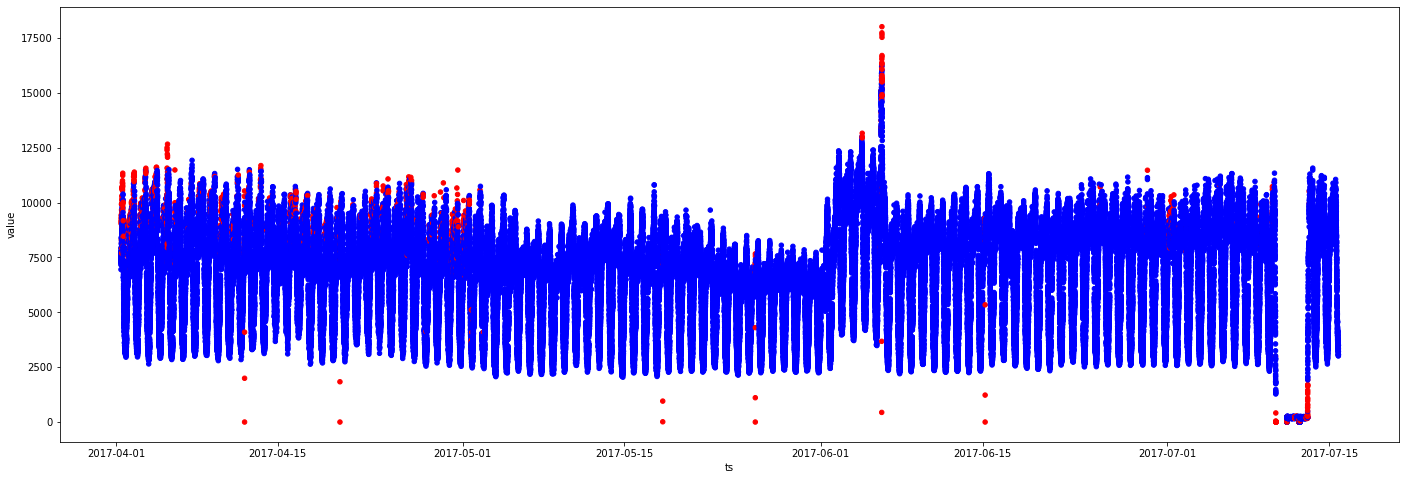

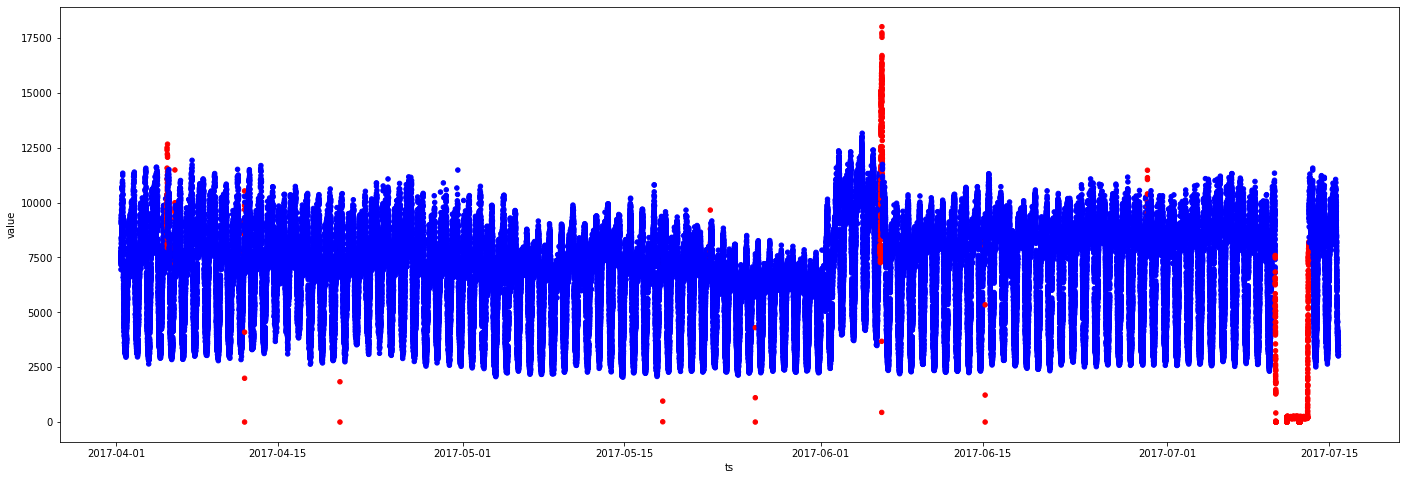

In [672]:
plt.rcParams['figure.figsize'] = (24,8)
df.plot(x="ts", y="value", kind="scatter", c=['b' if l==0 else 'r' for l in df["pred"]])
df.plot(x="ts", y="value", kind="scatter", c=['b' if l==0 else 'r' for l in df["label"]])
plt.show()

In [673]:
X_df = df.iloc[:, 3:-2]
X_df["value"] = df["value"]
X_df["label"] = df["label"]


adnormal_X = X_df[X_df['label']==1].iloc[:, :-1]
sample_size = len(adnormal_X)
normal_X = X_df[X_df['label']!=1].iloc[:, :-1]
normal_X = normal_X.sample(n=sample_size)

X = np.r_[normal_X.values, adnormal_X.values]
y = np.r_[np.zeros(sample_size), np.ones(sample_size)]


In [674]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X, y)
#model = SelectFromModel(rf)
#X_new = model.transform(X)

RandomForestClassifier()

In [675]:
model = SelectFromModel(rf, prefit=True)

In [676]:
feature_idx = model.get_support() 

In [677]:
X_df.iloc[:, :-1].columns[feature_idx]

Index(['weekofyear', 'rolling_10_avg', 'rolling_10_median', 'rolling_10_max',
       'rolling_10_min', 'rolling_10_mad', 'rolling_10_cov', 'rolling_10_q1',
       'rolling_10_q3', 'rolling_10_ewma', 'rolling_10_linear_trend_intercept',
       'value'],
      dtype='object')

In [678]:
new_df = df.loc[:, X_df.iloc[:, :-1].columns[feature_idx]]
new_df["value"] = df["value"]
new_df["label"] = df["label"]

In [679]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(contamination=0.01)
iforest.fit(new_df.iloc[:,:-1].values)
pred = iforest.predict(new_df.iloc[:,:-1].values)
df['newpred'] = np.where(pred==1, 0, 1)

/var/folders/97/nf61081d1l7135m5v32qhhxc0000gn/T/ipykernel_57163/3859989669.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['newpred'] = np.where(pred==1, 0, 1)


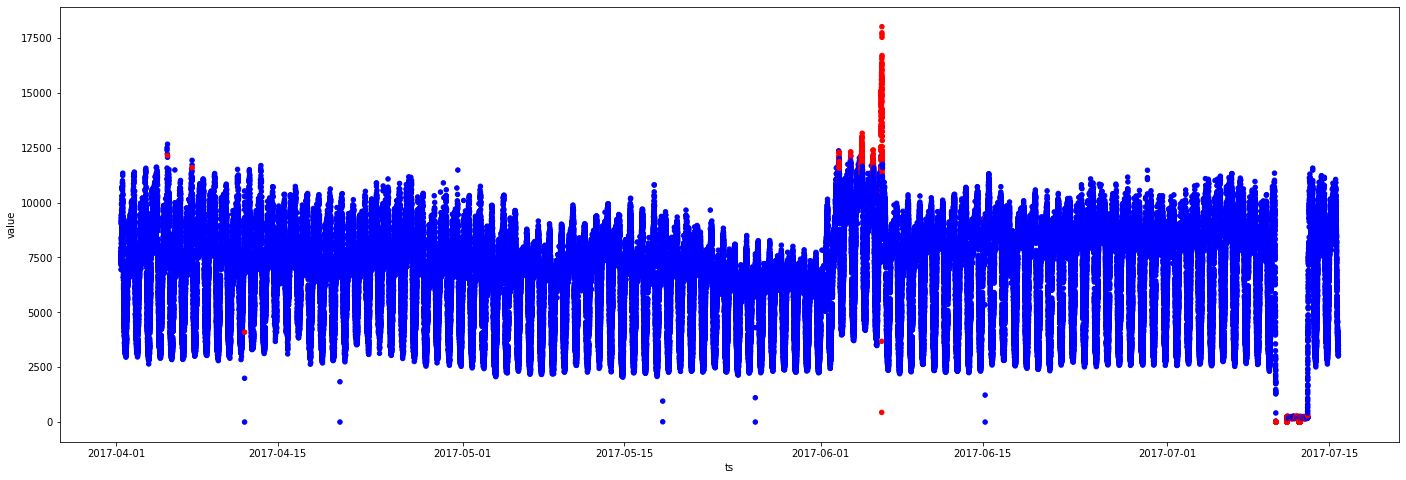

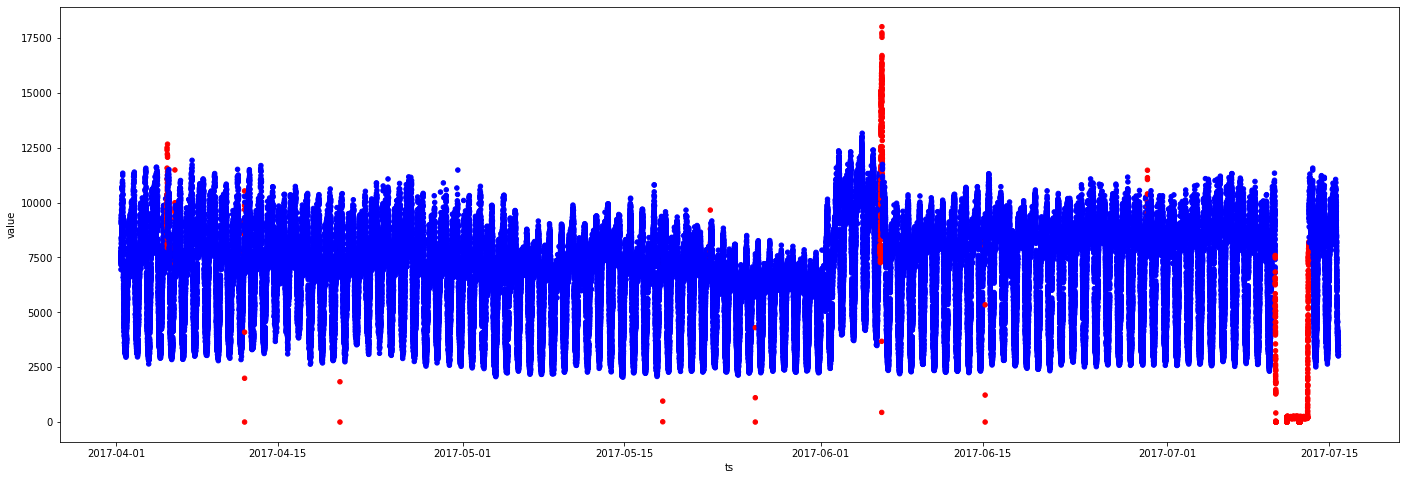

In [680]:
plt.rcParams['figure.figsize'] = (24,8)
df.plot(x="ts", y="value", kind="scatter", c=['b' if l==0 else 'r' for l in df["newpred"]])
df.plot(x="ts", y="value", kind="scatter", c=['b' if l==0 else 'r' for l in df["label"]])
plt.show()

In [681]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score


In [682]:
ret_before = classification_report(df['label'], df['pred'])
ret_after = classification_report(df['label'], df['newpred'])

print(ret_before, ret_after)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    143940
           1       0.41      0.20      0.27      3074

    accuracy                           0.98    147014
   macro avg       0.70      0.60      0.63    147014
weighted avg       0.97      0.98      0.97    147014
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    143940
           1       0.83      0.39      0.53      3074

    accuracy                           0.99    147014
   macro avg       0.91      0.69      0.76    147014
weighted avg       0.98      0.99      0.98    147014



In [683]:
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier()

ad_X = new_df[new_df['label']==1]
n_X = new_df[new_df['label']==0].sample(len(ad_X))

ad_y = np.ones(len(ad_X))
n_y = np.zeros(len(n_X))

randomforest.fit(np.r_[ad_X.iloc[:, :-1].values, n_X.iloc[:, :-1].values], np.r_[ad_y, n_y])

RandomForestClassifier()

In [684]:

pred = randomforest.predict(new_df.iloc[:, :-1].values)
df['newpred2'] = pred

/var/folders/97/nf61081d1l7135m5v32qhhxc0000gn/T/ipykernel_57163/3649207414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['newpred2'] = pred


In [685]:
print(classification_report(df['label'], pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    143940
           1       0.73      1.00      0.85      3074

    accuracy                           0.99    147014
   macro avg       0.87      1.00      0.92    147014
weighted avg       0.99      0.99      0.99    147014



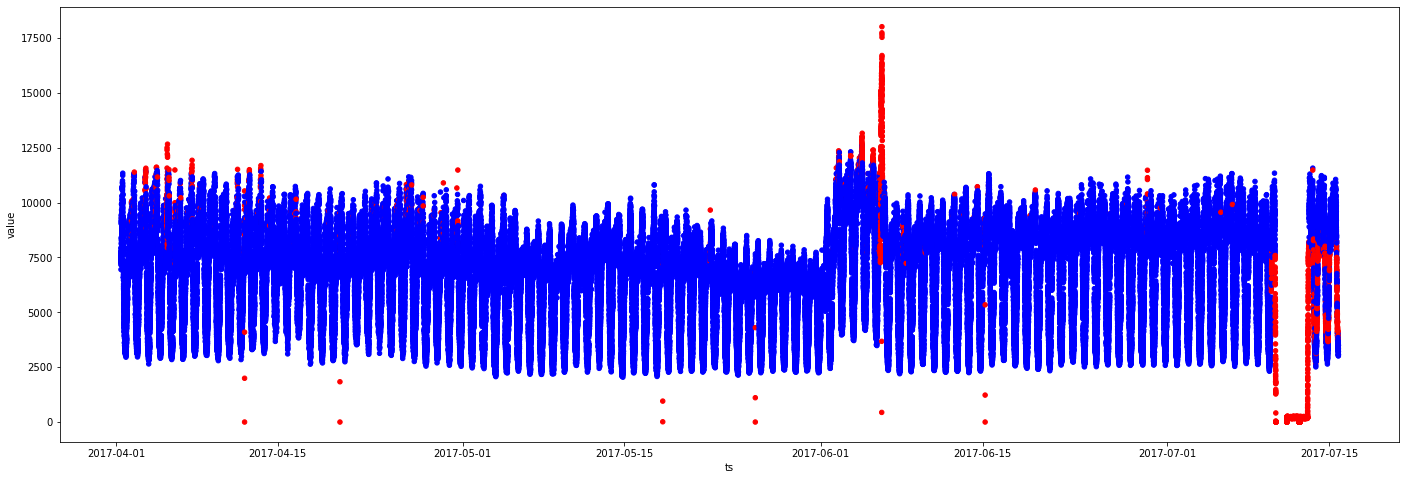

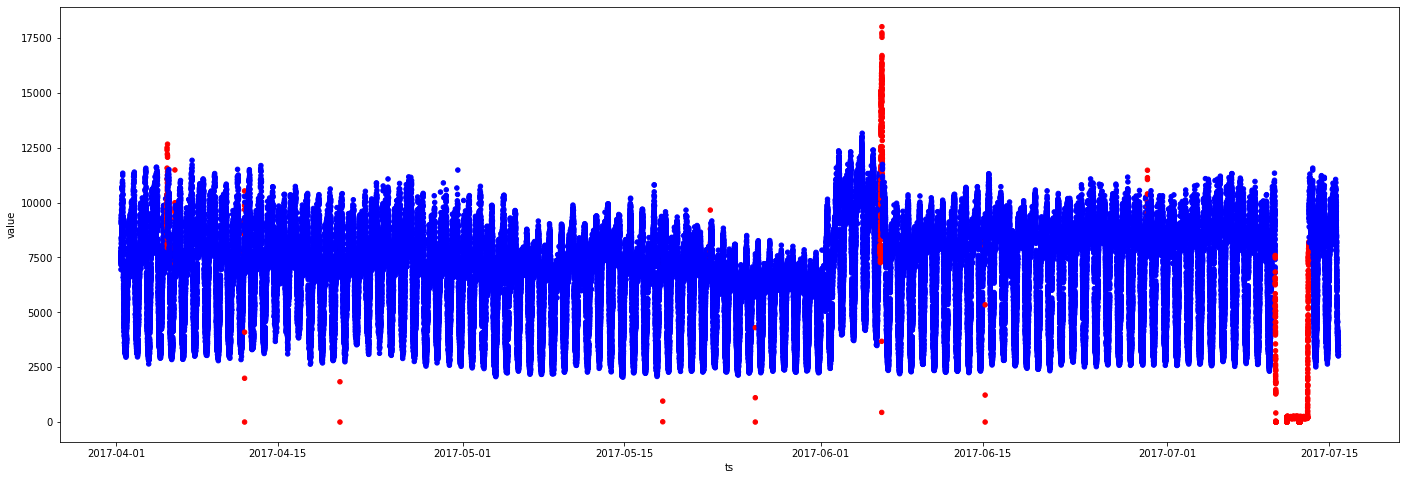

In [686]:
plt.rcParams['figure.figsize'] = (24,8)
df.plot(x="ts", y="value", kind="scatter", c=['b' if l==0 else 'r' for l in df["newpred2"]])
df.plot(x="ts", y="value", kind="scatter", c=['b' if l==0 else 'r' for l in df["label"]])
plt.show()